In [1]:
# The idea behind this is that players in the madden video games have 0-99 overall ratings
# and a bunch of other 0-99 ratings for specific attributes like speed, awareness, throw power, etc.
# my idea behind this project is to use regression to get the overall rating from these more specific ratings

In [2]:
import pandas
import statsmodels.api as sm
import numpy as np
from patsy import dmatrices

In [3]:
def get_new_params(n, params,data):
    top_weights = params[1:].sort_values(ascending=False).to_numpy()[:n] #the 1: removes the intercept
    top_features = params[1:].sort_values(ascending=False).index.to_numpy()[:n]
    dict = {}
    for a, b in zip(top_features, top_weights):
        dict[a] = b
    # print(dict)
    string = 'overall_rating ~ '
    for i in dict:
        string+= i+'+'
    string =string[:-1]
    y2, X2 =dmatrices(string, data=data, return_type='dataframe')
    mod_new = sm.OLS(y2, X2)
    res_new = mod_new.fit()
    # print(res_new.params)
    return res_new.params

In [4]:
def validate(validation,params):
    top_weights = params[1:].to_numpy()
    top_features = params[1:].index.to_numpy()
    dict = {}
    for a, b in zip(top_features, top_weights):
        dict[a] = b
    #print(dict)
    array=[]
    for i in dict:
        array.append(i)
    #print(array)
    features=validation[array].to_numpy()
    labels=validation[['overall_rating']].to_numpy()
    weights=params.to_numpy()
    #print(features)
    #print(weights[1:])
    errors=np.matmul(features,weights[1:])+weights[0]-labels.transpose()
    return np.average(np.absolute(errors))

In [31]:
def doRegression(data, Position):
    weights = np.zeros(shape=(1,53))

    pos=data[data['Position']==Position] # filtering data for given position 
    pos_ratings=pos[['awareness_rating','throwPower_rating','kickReturn_rating','leadBlock_rating','strength_rating','bCVision_rating','catchInTraffic_rating','playAction_rating','pursuit_rating','mediumRouteRunning_rating','catching_rating','acceleration_rating','spinMove_rating','finesseMoves_rating','spectacularCatch_rating','runBlock_rating','tackle_rating','injury_rating','zoneCoverage_rating','deepRouteRunning_rating','trucking_rating','throwAccuracyShort_rating','jukeMove_rating','playRecognition_rating','shortRouteRunning_rating','breakSack_rating','speed_rating','runBlockPower_rating','jumping_rating','toughness_rating','throwOnTheRun_rating','manCoverage_rating','stiffArm_rating','powerMoves_rating','release_rating','hitPower_rating','throwAccuracyMid_rating','kickAccuracy_rating','passBlockPower_rating','impactBlocking_rating','stamina_rating','carrying_rating','breakTackle_rating','kickPower_rating','throwUnderPressure_rating','passBlock_rating','changeOfDirection_rating','press_rating','throwAccuracyDeep_rating','blockShedding_rating','runBlockFinesse_rating','agility_rating','overall_rating','passBlockFinesse_rating']]
    # ^ These ratings are the ones that could matter so I'm only looking at these ones
    training=pos_ratings.sample(frac=.8,random_state=1) # take 80% as training data
    validation_rows=np.setdiff1d(pos_ratings.index,training.index)
    array=np.zeros(data.index.size)
    for n in range(data.index.size):
        array[n]=(n in validation_rows)
        array=np.array(array,dtype=bool)

    validation=data.loc[array]

    validation=validation[['overall_rating','awareness_rating','throwPower_rating','kickReturn_rating','leadBlock_rating','strength_rating','bCVision_rating','catchInTraffic_rating','playAction_rating','pursuit_rating','mediumRouteRunning_rating','catching_rating','acceleration_rating','spinMove_rating','finesseMoves_rating','spectacularCatch_rating','runBlock_rating','tackle_rating','injury_rating','zoneCoverage_rating','deepRouteRunning_rating','trucking_rating','throwAccuracyShort_rating','jukeMove_rating','playRecognition_rating','shortRouteRunning_rating','breakSack_rating','speed_rating','runBlockPower_rating','jumping_rating','toughness_rating','throwOnTheRun_rating','manCoverage_rating','stiffArm_rating','powerMoves_rating','release_rating','hitPower_rating','throwAccuracyMid_rating','kickAccuracy_rating','passBlockPower_rating','impactBlocking_rating','stamina_rating','carrying_rating','breakTackle_rating','kickPower_rating','throwUnderPressure_rating','passBlock_rating','changeOfDirection_rating','press_rating','throwAccuracyDeep_rating','blockShedding_rating','runBlockFinesse_rating','agility_rating','passBlockFinesse_rating']]
    # makes the rest of the data the validation set
   
    y, X =dmatrices('overall_rating ~ awareness_rating+throwPower_rating+kickReturn_rating+leadBlock_rating+strength_rating+bCVision_rating+catchInTraffic_rating+playAction_rating+pursuit_rating+mediumRouteRunning_rating+catching_rating+acceleration_rating+spinMove_rating+finesseMoves_rating+spectacularCatch_rating+runBlock_rating+tackle_rating+injury_rating+zoneCoverage_rating+deepRouteRunning_rating+trucking_rating+throwAccuracyShort_rating+jukeMove_rating+playRecognition_rating+shortRouteRunning_rating+breakSack_rating+speed_rating+runBlockPower_rating+jumping_rating+toughness_rating+throwOnTheRun_rating+manCoverage_rating+stiffArm_rating+powerMoves_rating+release_rating+hitPower_rating+throwAccuracyMid_rating+kickAccuracy_rating+passBlockPower_rating+impactBlocking_rating+stamina_rating+carrying_rating+breakTackle_rating+kickPower_rating+throwUnderPressure_rating+passBlock_rating+changeOfDirection_rating+press_rating+throwAccuracyDeep_rating+blockShedding_rating+runBlockFinesse_rating+agility_rating+passBlockFinesse_rating',data=training, return_type='dataframe')
    # this line does the regression part
    mod = sm.OLS(y, X)
    res = mod.fit()

    feature_weights = res.params[1:].to_numpy() #the 1: removes the intercept
    weights = np.vstack([weights,feature_weights])

    error_array=np.zeros([res.params.to_numpy().size-1,1],dtype=float)
    size=res.params.to_numpy().size
    for n in range(size-1): # experiment with keeping 1,2,...,size-1 features (n goes from 0 to size-2)
        # n+1 is the number of features we are keeping
        new_params=get_new_params(n+1,res.params,training)
        error_array[n]=validate(validation,new_params)
    #print(error_array)
    optimal_params=1
    while(error_array[optimal_params-1]>1):
        optimal_params+=1
        if optimal_params==54:
            optimal_params-=1
            break
    print('Average absolute error for ' +Position + ': '+str(error_array[optimal_params-1]))
    print(weights[1:])
    return get_new_params(optimal_params,res.params,data) # we're training the model with the 

In [6]:
def findPositions(data):
    c = data.to_numpy()
    q = c[:, 2]
    return (np.unique(q))

In [67]:
data=pandas.read_csv('Madden_23_Player_Ratings.csv') # Read data
allPositions = findPositions(data)

#to print everything do this
for pos in allPositions:
    print(doRegression(data, pos))
    print('')

#or just one, do this
# print(doRegression(data, 'QB'))

# change the argument here to do regression on whichever position

Average absolute error for C: [0.82599256]
[[ 0.20735741  0.02027992 -0.2022678   0.10363395  0.25641208 -0.02400624
  -0.06840982  0.20846731 -0.05421802  0.03349618 -0.00665434  0.08646678
  -0.02504548  0.13966815  0.01227103  0.45253202 -0.00621662  0.01562093
   0.05210599 -0.09450426 -0.00059512  0.20846731  0.1097113  -0.00648152
   0.11019034 -0.20760218 -0.08159779  0.06571148 -0.00316962 -0.04015837
   0.20846731  0.09127459 -0.03400926 -0.1387326  -0.02294464 -0.01926393
   0.20846731 -0.11168599 -0.02803512  0.08531133 -0.08162252  0.04161318
   0.06337746  0.20341186 -0.07962229  0.44649652 -0.06767194 -0.35701003
   0.20846731  0.06677359 -0.00611781  0.07123751  0.01482828]]
Intercept                    4.435659
runBlock_rating              0.161061
passBlock_rating            -0.108568
strength_rating              0.129332
playAction_rating           -0.084840
throwAccuracyShort_rating    0.086154
throwOnTheRun_rating        -0.012706
throwAccuracyMid_rating      0.2626

In [8]:
# code snippet
# instead of taking top n features, we keep retraining the model, removing one feature at a time until there are n left
error_array=np.zeros([res.params.to_numpy().size-1,1],dtype=float)
size=res.params.to_numpy().size
for n in range(size-1): # experiment with keeping 1,2,...,size-1 features (n goes from 0 to size-2)
        # n+1 is the number of features we are keeping
    new_params=res.params
    for j in range(size-n-1): # if n+1=5 and size=7, we will need to remove 2 features
            # j goes from 0 to size-n-2
        new_params=get_new_params(size-j-1,new_params,training)
    error_array[n]=validate(validation,new_params)

NameError: name 'res' is not defined

In [ ]:
# this code snippet takes the initial weight values from a single model and stores the weights for each position into an array

feature_names = ['awareness_rating','throwPower_rating','kickReturn_rating','leadBlock_rating','strength_rating','bCVision_rating','catchInTraffic_rating','playAction_rating','pursuit_rating','mediumRouteRunning_rating','catching_rating','acceleration_rating','spinMove_rating','finesseMoves_rating','spectacularCatch_rating','runBlock_rating','tackle_rating','injury_rating','zoneCoverage_rating','deepRouteRunning_rating','trucking_rating','throwAccuracyShort_rating','jukeMove_rating','playRecognition_rating','shortRouteRunning_rating','breakSack_rating','speed_rating','runBlockPower_rating','jumping_rating','toughness_rating','throwOnTheRun_rating','manCoverage_rating','stiffArm_rating','powerMoves_rating','release_rating','hitPower_rating','throwAccuracyMid_rating','kickAccuracy_rating','passBlockPower_rating','impactBlocking_rating','stamina_rating','carrying_rating','breakTackle_rating','kickPower_rating','throwUnderPressure_rating','passBlock_rating','changeOfDirection_rating','press_rating','throwAccuracyDeep_rating','blockShedding_rating','runBlockFinesse_rating','agility_rating','passBlockFinesse_rating']
weights = np.zeros(shape=(1,53))

positions = data['Position'].unique()
for pos in positions:
    players=data[data['Position']==pos] # filtering data for given position 
    ratings=players[['awareness_rating','throwPower_rating','kickReturn_rating','leadBlock_rating','strength_rating','bCVision_rating','catchInTraffic_rating','playAction_rating','pursuit_rating','mediumRouteRunning_rating','catching_rating','acceleration_rating','spinMove_rating','finesseMoves_rating','spectacularCatch_rating','runBlock_rating','tackle_rating','injury_rating','zoneCoverage_rating','deepRouteRunning_rating','trucking_rating','throwAccuracyShort_rating','jukeMove_rating','playRecognition_rating','shortRouteRunning_rating','breakSack_rating','speed_rating','runBlockPower_rating','jumping_rating','toughness_rating','throwOnTheRun_rating','manCoverage_rating','stiffArm_rating','powerMoves_rating','release_rating','hitPower_rating','throwAccuracyMid_rating','kickAccuracy_rating','passBlockPower_rating','impactBlocking_rating','stamina_rating','carrying_rating','breakTackle_rating','kickPower_rating','throwUnderPressure_rating','passBlock_rating','changeOfDirection_rating','press_rating','throwAccuracyDeep_rating','blockShedding_rating','runBlockFinesse_rating','agility_rating','overall_rating','passBlockFinesse_rating']]
    # ^ These ratings are the ones that could matter so I'm only looking at these ones
    training=ratings.sample(frac=.8,random_state=1) # take 80% as training data
    validation_rows=np.setdiff1d(ratings.index,training.index)
    array=np.zeros(data.index.size)
    for n in range(data.index.size):
        array[n]=(n in validation_rows)
        array=np.array(array,dtype=bool)

    validation=data.loc[array]

    validation=validation[['overall_rating','awareness_rating','throwPower_rating','kickReturn_rating','leadBlock_rating','strength_rating','bCVision_rating','catchInTraffic_rating','playAction_rating','pursuit_rating','mediumRouteRunning_rating','catching_rating','acceleration_rating','spinMove_rating','finesseMoves_rating','spectacularCatch_rating','runBlock_rating','tackle_rating','injury_rating','zoneCoverage_rating','deepRouteRunning_rating','trucking_rating','throwAccuracyShort_rating','jukeMove_rating','playRecognition_rating','shortRouteRunning_rating','breakSack_rating','speed_rating','runBlockPower_rating','jumping_rating','toughness_rating','throwOnTheRun_rating','manCoverage_rating','stiffArm_rating','powerMoves_rating','release_rating','hitPower_rating','throwAccuracyMid_rating','kickAccuracy_rating','passBlockPower_rating','impactBlocking_rating','stamina_rating','carrying_rating','breakTackle_rating','kickPower_rating','throwUnderPressure_rating','passBlock_rating','changeOfDirection_rating','press_rating','throwAccuracyDeep_rating','blockShedding_rating','runBlockFinesse_rating','agility_rating','passBlockFinesse_rating']]
    # makes the rest of the data the validation set

    y, X =dmatrices('overall_rating ~ awareness_rating+throwPower_rating+kickReturn_rating+leadBlock_rating+strength_rating+bCVision_rating+catchInTraffic_rating+playAction_rating+pursuit_rating+mediumRouteRunning_rating+catching_rating+acceleration_rating+spinMove_rating+finesseMoves_rating+spectacularCatch_rating+runBlock_rating+tackle_rating+injury_rating+zoneCoverage_rating+deepRouteRunning_rating+trucking_rating+throwAccuracyShort_rating+jukeMove_rating+playRecognition_rating+shortRouteRunning_rating+breakSack_rating+speed_rating+runBlockPower_rating+jumping_rating+toughness_rating+throwOnTheRun_rating+manCoverage_rating+stiffArm_rating+powerMoves_rating+release_rating+hitPower_rating+throwAccuracyMid_rating+kickAccuracy_rating+passBlockPower_rating+impactBlocking_rating+stamina_rating+carrying_rating+breakTackle_rating+kickPower_rating+throwUnderPressure_rating+passBlock_rating+changeOfDirection_rating+press_rating+throwAccuracyDeep_rating+blockShedding_rating+runBlockFinesse_rating+agility_rating+passBlockFinesse_rating',data=training, return_type='dataframe')
    # this line does the regression part
    mod = sm.OLS(y, X)
    res = mod.fit()

    feature_weights = res.params[1:].to_numpy() #the 1: removes the intercept
    weights = np.vstack([weights,feature_weights])

print(weights[1:])

In [66]:
# heatmap generated through the pandas library

import pandas as pd

weights_ = weights[1:]
df = pd.DataFrame(weights[1:], columns=feature_names, index = positions)
df.style.background_gradient(cmap ='coolwarm')\
        .set_properties(**{'font-size': '20px'})

,awareness_rating,throwPower_rating,kickReturn_rating,leadBlock_rating,strength_rating,bCVision_rating,catchInTraffic_rating,playAction_rating,pursuit_rating,mediumRouteRunning_rating,catching_rating,acceleration_rating,spinMove_rating,finesseMoves_rating,spectacularCatch_rating,runBlock_rating,tackle_rating,injury_rating,zoneCoverage_rating,deepRouteRunning_rating,trucking_rating,throwAccuracyShort_rating,jukeMove_rating,playRecognition_rating,shortRouteRunning_rating,breakSack_rating,speed_rating,runBlockPower_rating,jumping_rating,toughness_rating,throwOnTheRun_rating,manCoverage_rating,stiffArm_rating,powerMoves_rating,release_rating,hitPower_rating,throwAccuracyMid_rating,kickAccuracy_rating,passBlockPower_rating,impactBlocking_rating,stamina_rating,carrying_rating,breakTackle_rating,kickPower_rating,throwUnderPressure_rating,passBlock_rating,changeOfDirection_rating,press_rating,throwAccuracyDeep_rating,blockShedding_rating,runBlockFinesse_rating,agility_rating,passBlockFinesse_rating
RE,0.234231,-0.011049,-0.086672,-0.050920,0.167848,0.031591,0.009904,-1.912531,0.124296,0.370909,0.057258,0.094429,0.077447,0.127580,-0.086601,-1.595867,0.388173,-0.019130,-0.006959,-0.306916,-0.047542,0.087546,-0.058547,0.054158,-0.095311,0.222444,0.116366,0.266559,0.029565,0.013257,0.245172,0.056114,0.005809,0.094231,-0.011368,0.054587,0.177414,0.096422,-0.561195,0.117646,0.064714,0.037575,0.040128,-0.126478,-0.100293,1.740997,0.027092,-0.005715,0.639920,0.051421,1.125142,-0.011738,-0.303176
WR,0.142082,0.003270,0.002808,0.038511,0.006355,0.061427,0.121171,0.002719,0.009864,0.184879,0.125070,0.150950,-0.007327,-0.011014,0.175865,-0.012784,-0.001885,-0.034344,-0.041445,0.085681,0.005737,0.025378,0.139312,-0.019026,0.110887,0.008136,0.201964,0.009575,0.011544,-0.016806,-0.019938,0.045545,0.004008,-0.008301,0.050788,0.001678,0.054405,-0.014874,0.011053,-0.041280,0.043312,0.012057,0.030704,0.014239,-0.028020,0.012262,0.069793,-0.000846,-0.049603,-0.007792,-0.010315,0.123472,-0.013832
LT,0.153504,-0.011467,0.404341,-0.074590,0.103657,-0.027986,-0.114742,2.383605,-0.032175,0.193789,0.037017,0.107719,-0.034468,-0.039478,-0.043804,-0.210104,0.140174,-0.072850,-0.075463,-0.032924,-0.138938,0.304516,-0.037682,-0.076839,0.066434,0.109249,-0.029500,0.484494,0.053435,-0.036629,-0.474596,-0.072757,0.089785,0.099381,0.032010,-0.039072,-0.443510,0.019272,-0.121187,0.194194,-0.049853,-0.011170,0.069601,0.041764,-0.204438,0.532015,-0.077718,0.408489,0.322557,-0.075583,0.307037,0.046206,0.095623
CB,0.225510,0.000108,0.001669,-0.008160,0.005778,-0.001413,0.006669,-0.006322,0.006791,0.019246,0.045080,0.298932,-0.005865,0.007322,0.009887,-0.007848,0.079245,0.012843,0.111963,-0.008973,0.000876,0.017903,0.012961,0.068224,-0.021350,0.000361,0.335889,0.105244,0.037908,-0.002528,-0.020042,0.319853,-0.001735,-0.005082,0.009114,-0.000971,0.012902,0.012218,0.010187,0.004233,0.012674,0.000088,-0.008910,-0.007886,-0.008825,-0.001335,0.099035,0.087902,-0.011333,0.012575,-0.123354,0.040367,0.023500
TE,0.246243,0.041589,0.019552,-0.040286,0.106150,0.041109,0.191990,0.018193,-0.009261,0.131929,0.164973,0.147162,0.069363,0.080072,0.041026,0.191244,0.049407,-0.029184,-0.088895,0.097704,-0.057596,-0.009448,-0.021402,-0.000848,0.155285,0.043307,-0.119814,0.084281,0.110635,0.032557,-0.002700,0.147489,0.067469,-0.096401,0.003460,0.017494,0.091787,-0.012318,-0.236096,-0.000430,-0.055075,-0.039130,0.077167,0.001822,-0.086720,0.210003,-0.007375,-0.006903,-0.122028,-0.051022,0.081270,0.117271,0.222680
RG,0.136804,-0.027479,-1.276614,0.186964,0.244432,-0.038521,0.049460,1.257320,-0.030526,-0.175030,0.040634,0.071711,-0.176945,0.011646,-0.010063,0.470784,-0.006408,0.094719,0.004738,0.071357,0.000645,0.452041,0.139780,-0.018128,-0.073378,0.076098,0.008905,-0.039086,-0.039484,-0.025516,-0.316030,0.074420,-0.010296,0.023386,0.125759,-0.011232,-0.986961,0.076415,1.011159,0.094205,-0.001066,-0.070372,0.059722,-0.068629,-0.010875,-1.224702,0.021889,-0.053732,-0.651496,-0.001908,-0.140962,0.0

<AxesSubplot:>

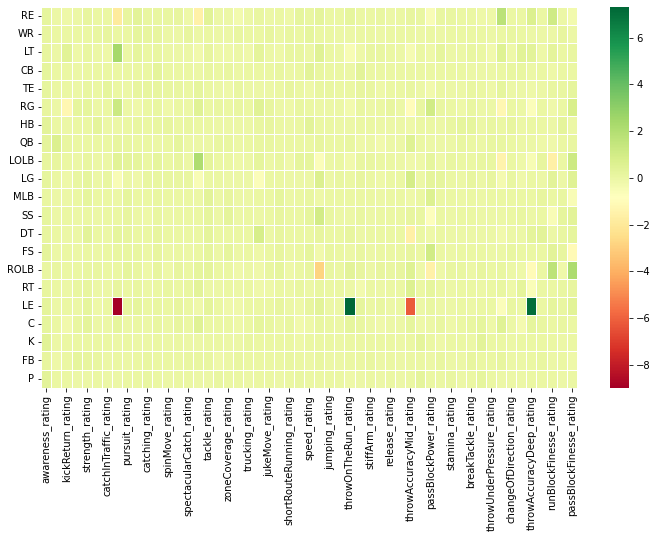

In [83]:
# alternate heatmap using sns the same weight values
# outliers found in the model paramters for LE (left end)

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (12, 7))

df = pd.DataFrame(weights[1:], columns=feature_names, index = positions)
sns.heatmap(df, cmap ='RdYlGn', linewidths = 1) # RdYlGn is a bit easier to read than coolwarm for this one
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)